In [33]:
import os
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")


In [34]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense , Dropout , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.utils import class_weight
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint ,ReduceLROnPlateau
from sklearn.metrics import classification_report , confusion_matrix
from tensorflow.keras.models import load_model



In [35]:
original_dir = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset"
output_dir = "Data_split"

In [36]:
for category in ['yes', 'no']:
    category_path = os.path.join(original_dir, category)
    images = os.listdir(category_path)

    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)

    for split, split_imgs in [('train', train_imgs), ('test', test_imgs)]:
        split_path = os.path.join(output_dir, split, category)
        os.makedirs(split_path, exist_ok=True)

        for img in split_imgs:
            src = os.path.join(category_path, img)
            dst = os.path.join(split_path, img)
            shutil.copy(src, dst)


In [37]:
img_size = 224
batch_size = 16

train_data_gen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2,
    rotation_range = 10,
    zoom_range = 0.1,
    shear_range=0.1,
    horizontal_flip = True,
    fill_mode='nearest'

    
)

In [38]:
train_generator = train_data_gen.flow_from_directory(
    'Data_split/train',
    target_size = (img_size , img_size),
    batch_size = batch_size,
    class_mode = "binary",
    subset = "training",
    seed=42,
    shuffle = True
    
)

val_generator = train_data_gen.flow_from_directory(
    'Data_split/train',
    target_size = (img_size , img_size),
    batch_size = batch_size,
    class_mode = "binary",
    subset = "validation",
    seed=42,
    shuffle = False
    
)

Found 163 images belonging to 2 classes.
Found 39 images belonging to 2 classes.


In [39]:
print(train_generator.class_indices)  


{'no': 0, 'yes': 1}


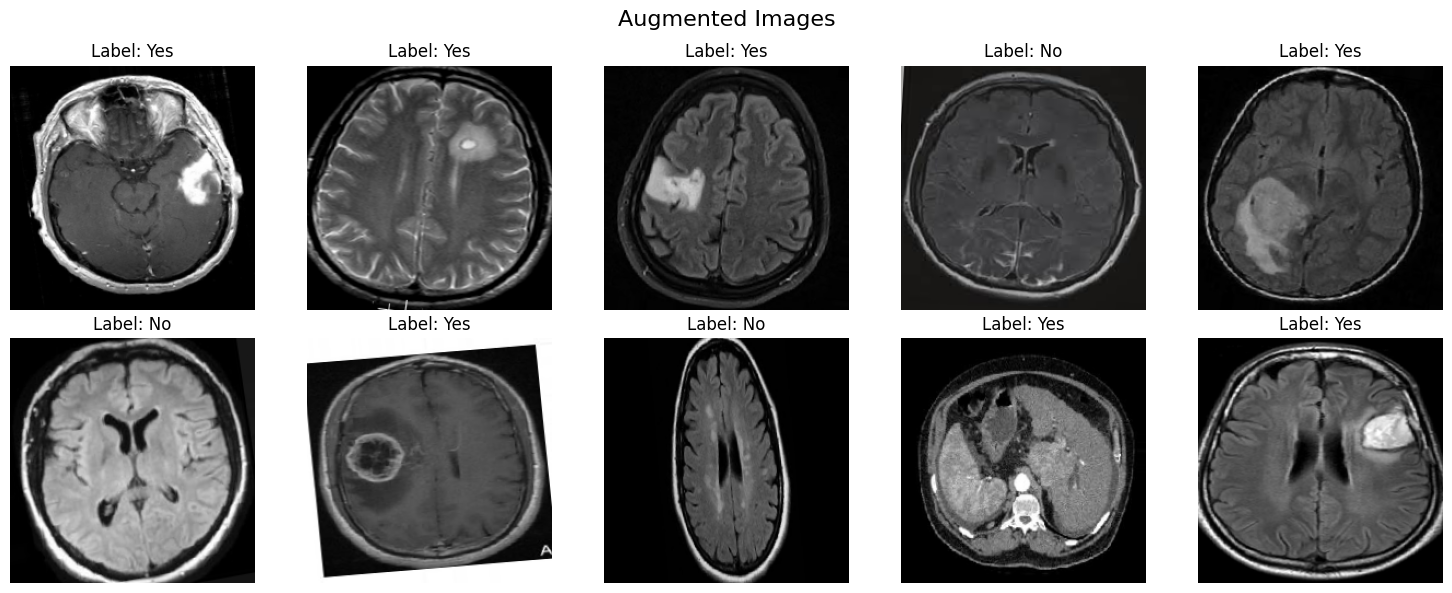

In [40]:
images, labels = next(train_generator)

plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    label = "Yes" if labels[i] == 1 else "No"
    plt.title(f"Label: {label}")
plt.suptitle("Augmented Images", fontsize=16)
plt.tight_layout()
plt.show()


In [41]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weights_dict)


Class Weights: {0: 1.2936507936507937, 1: 0.815}


In [42]:
base_model = MobileNetV2(weights = 'imagenet' , include_top = False , input_shape = (img_size , img_size , 3))
base_model.trainable = False

In [43]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [44]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
check_point = ModelCheckpoint("BrainTumor_classification_model.h5" , monitor = ' val_loss' , save_best_only = True)


In [45]:
model.compile(optimizer = Adam(1e-4) , loss = 'binary_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [46]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    class_weight = class_weights_dict,
    callbacks=[early_stop , check_point , reduce_lr]

)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 933ms/step - accuracy: 0.5721 - loss: 0.7351 - val_accuracy: 0.7692 - val_loss: 0.5301 - learning_rate: 1.0000e-04
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.6067 - loss: 0.6866 - val_accuracy: 0.7692 - val_loss: 0.5532 - learning_rate: 1.0000e-04
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.6059 - loss: 0.6624 - val_accuracy: 0.7692 - val_loss: 0.5028 - learning_rate: 1.0000e-04
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.7008 - loss: 0.5858 - val_accuracy: 0.8462 - val_loss: 0.4328 - learning_rate: 1.0000e-04
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.6899 - loss: 0.5655 - val_accuracy: 0.7949 - val_loss: 0.4504 - learning_rate: 1.0000e-04
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - accuracy: 0.7920 - loss: 0.5145 - val_accuracy: 0.8718 - val_loss: 0.4058 - learning_rate: 1.0000e-04
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy:

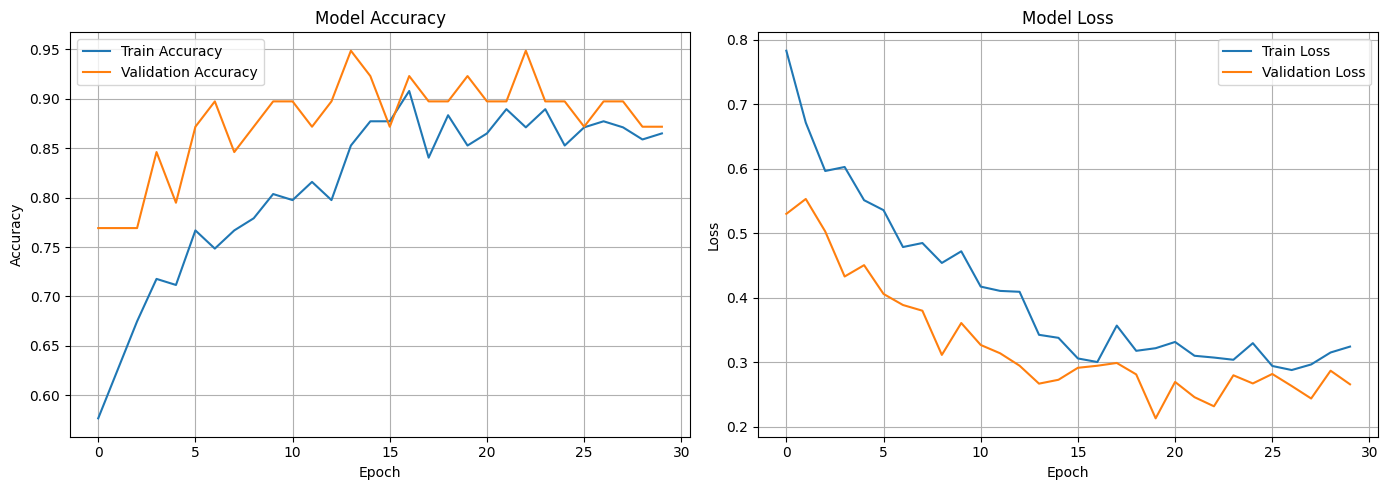

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))  

# Accuracy Plot
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Loss Plot
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [56]:
model.save("BrainTumor_classification_model.h5")

In [57]:
test_data_gen = ImageDataGenerator(rescale = 1./225)

test_generator = test_data_gen.flow_from_directory(
    'Data_split/test',
     target_size=(img_size, img_size),
     batch_size=16,
     class_mode='binary',
     shuffle=False
)

Found 51 images belonging to 2 classes.


In [58]:
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int)  


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 978ms/step


In [59]:
y_true = test_generator.classes

In [60]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        20
           1       0.90      0.87      0.89        31

    accuracy                           0.86        51
   macro avg       0.85      0.86      0.86        51
weighted avg       0.86      0.86      0.86        51



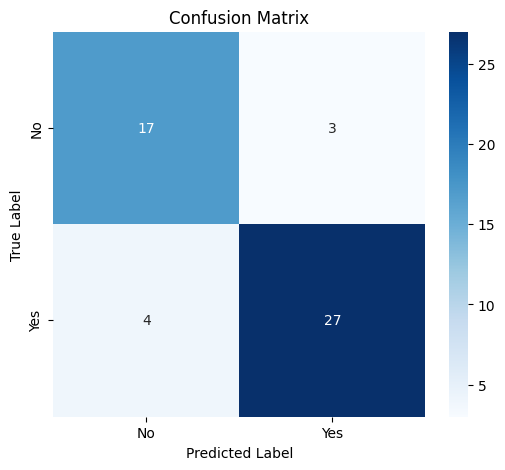

In [61]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [62]:
model = load_model("BrainTumor_classification_model.h5")

loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Loss: {loss:.2f}")



4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 477ms/step - accuracy: 0.8472 - loss: 0.3345
Test Accuracy: 86.27%
Loss: 0.31
